Data loading

In [74]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,KFold, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK


df = pd.read_csv('healthcare_dataset.csv')
df.head()

,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results
0,Bobby JacksOn,30,Male,B-,Cancer,2024-01-31,Matthew Smith,Sons and Miller,Blue Cross,18856.281306,328,Urgent,2024-02-02,Paracetamol,Normal
1,LesLie TErRy,62,Male,A+,Obesity,2019-08-20,Samantha Davies,Kim Inc,Medicare,33643.327287,265,Emergency,2019-08-26,Ibuprofen,Inconclusive
2,DaNnY sMitH,76,Female,A-,Obesity,2022-09-22,Tiffany Mitchell,Cook PLC,Aetna,27955.096079,205,Emergency,2022-10-07,Aspirin,Normal
3,andrEw waTtS,28,Female,O+,Diabetes,2020-11-18,Kevin Wells,"Hernandez Rogers and Vang,",Medicare,37909.782410,450,Elective,2020-12-18,Ibuprofen,Abnormal
4,adrIENNE bEll,43,Female,AB+,Cancer,2022-09-19,Kathleen Hanna,White-White,Aetna,14238.317814,458,Urgent,2022-10-09,Penicillin,Abnormal


In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55500 entries, 0 to 55499
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Name                55500 non-null  object 
 1   Age                 55500 non-null  int64  
 2   Gender              55500 non-null  object 
 3   Blood Type          55500 non-null  object 
 4   Medical Condition   55500 non-null  object 
 5   Date of Admission   55500 non-null  object 
 6   Doctor              55500 non-null  object 
 7   Hospital            55500 non-null  object 
 8   Insurance Provider  55500 non-null  object 
 9   Billing Amount      55500 non-null  float64
 10  Room Number         55500 non-null  int64  
 11  Admission Type      55500 non-null  object 
 12  Discharge Date      55500 non-null  object 
 13  Medication          55500 non-null  object 
 14  Test Results        55500 non-null  object 
dtypes: float64(1), int64(2), object(12)
memory usage: 6.4

Task 1

Preprocess Data


In [76]:
df['Date of Admission'] = pd.to_datetime(df['Date of Admission'])
df['Discharge Date'] = pd.to_datetime(df['Discharge Date'])

# # Calculate length of stay
df['Length of Stay'] = (df['Discharge Date'] - df['Date of Admission']).dt.days

# # Drop unnecessary columns
df_reg = df.drop(columns=["Name", "Doctor", "Hospital", "Room Number","Date of Admission","Discharge Date"])

# Handling missing values
df_reg = df_reg.dropna()

# One-Hot Encoding for categorical variables
categorical_columns = ["Gender", "Blood Type", "Medical Condition", "Insurance Provider", "Admission Type", "Medication", "Test Results"]
df_reg = pd.get_dummies(df_reg, columns=categorical_columns, drop_first=True)
X = df_reg.drop(columns=["Length of Stay"])
y = df_reg["Length of Stay"]

In [77]:
# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Model Development:

In [78]:
# Train and evaluate Linear Regression using K-Fold
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)


lr_pred = lr_model.predict(X_test)
lr_mae = mean_absolute_error(y_test, lr_pred)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred))
print(f"Linear Regression Mean Absolute Error: {lr_mae:.2f}")
print(f"Linear Regression RMSE: {lr_rmse:.2f}")

Linear Regression Mean Absolute Error: 7.48
Linear Regression RMSE: 8.63


In [79]:

space = {
    'n_estimators': hp.choice('n_estimators', [50, 100, 200, 300, 500]),
    'max_depth': hp.choice('max_depth', [3, 5, 10, 15, 20]),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.1),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1),
    'gamma': hp.uniform('gamma', 0, 1),
    'min_child_weight': hp.uniform('min_child_weight', 1, 10)
}


def objective(params):
    model = XGBRegressor(
        n_estimators=params['n_estimators'],
        max_depth=params['max_depth'],
        learning_rate=params['learning_rate'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        gamma=params['gamma'],
        min_child_weight=params['min_child_weight'],

    )



    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
    mean_mse = np.mean(cv_scores)
    return {'loss': -mean_mse, 'status': STATUS_OK}


trials = Trials()
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials
)


best_params = {
    'n_estimators': [50, 100, 200, 300, 500][best['n_estimators']],
    'max_depth': [3, 5, 10, 15, 20][best['max_depth']],
    'learning_rate': best['learning_rate'],
    'subsample': best['subsample'],
    'colsample_bytree': best['colsample_bytree'],
    'gamma': best['gamma'],
    'min_child_weight': best['min_child_weight'],

}


xgb_model = XGBRegressor(**best_params, random_state=42)
xgb_model.fit(X_train, y_train)


100%|██████████| 50/50 [18:53<00:00, 22.67s/trial, best loss: 73.20994262695312]


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=np.float64(0.5096235806314614), device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None,
             gamma=np.float64(0.11763303254412999), grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=np.float64(0.020603528152211982), max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=20, max_leaves=None,
             min_child_weight=np.float64(1.968091308908991), missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [80]:

y_pred_test = xgb_model.predict(X_test)
mae_best = mean_absolute_error(y_test, y_pred_test)
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"Tuned XGBoost Regression Mean Absolute Error: {mae_best:.2f}")
print(f"Tuned XGBoost Regression RMSE: {rmse_best:.2f}")


Tuned XGBoost Regression Mean Absolute Error: 7.32
Tuned XGBoost Regression RMSE: 8.50


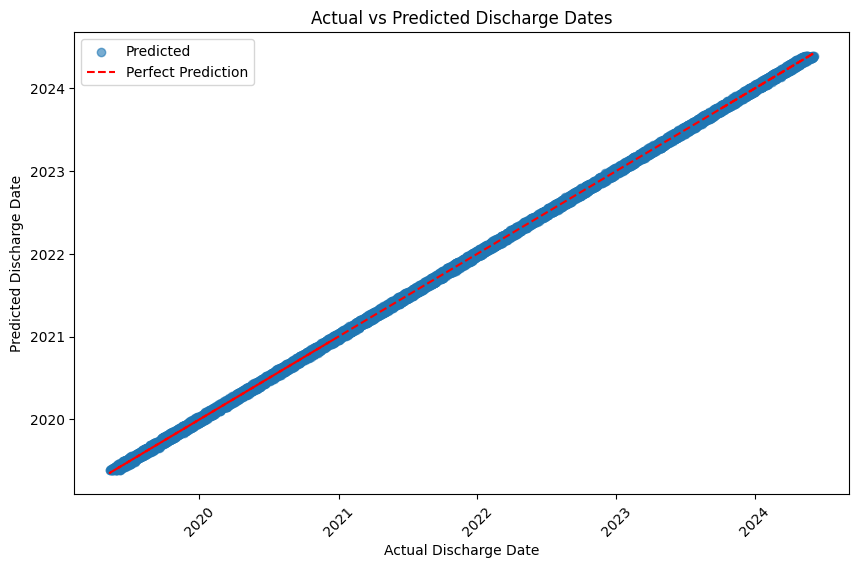

In [81]:
# Convert predictions to actual discharge dates
y_pred_discharge = df["Date of Admission"].iloc[y_test.index] + pd.to_timedelta(y_pred_test, unit='D')

# Plot Actual vs. Predicted Discharge Dates
plt.figure(figsize=(10, 6))
plt.scatter(df["Discharge Date"].iloc[y_test.index], y_pred_discharge, alpha=0.6, label="Predicted")
plt.plot(df["Discharge Date"].iloc[y_test.index], df["Discharge Date"].iloc[y_test.index], 'r--', label="Perfect Prediction")
plt.xlabel("Actual Discharge Date")
plt.ylabel("Predicted Discharge Date")
plt.title("Actual vs Predicted Discharge Dates")
plt.legend()
plt.xticks(rotation=45)
plt.show()

**Business implications and suggestions for hospital bed management.**

Predicting discharge dates accurately helps hospitals free up beds in advance, reducing waiting times for incoming patients.
Efficient bed turnover increases the number of patients treated, boosting hospital revenue while reducing overtime labor costs.
 Reduced waiting times and timely discharges improve patient experience and increase hospital ratings.


 Use predictive models to notify doctors and nurses in advance about patients likely to be discharged.
 If a model predicts higher patient inflow, hospitals can adjust shift schedules to ensure adequate staff availability.

In [82]:
#Business implications and suggestions for hospital bed management.



Evaluation Metrics:

Task 2

In [83]:
# Define High-Risk Patients (Binary Classification)
df_class = df.copy()
# df_class["High Risk"] = df_class["Medical Condition"].apply(lambda x: 1 if x in ["Diabetes", "Hypertension", "Heart Disease"] else 0)
conditions = ['Diabetes', 'Cancer', 'Asthma','Hypertension']
df_class['High Risk'] = ((df['Medical Condition'].isin(conditions)) |
                   (df['Test Results'] == 'Abnormal')) & (df['Age'] > 60)
# Drop unnecessary columns
df_class = df_class.drop(columns=["Name", "Doctor", "Hospital", "Room Number", "Date of Admission", "Discharge Date", "Length of Stay"])

# Handling missing values
df_class = df_class.dropna()

categorical_columns = ['Gender', 'Blood Type', 'Admission Type', 'Test Results','Medical Condition', 'Medication','Insurance Provider']


# One-Hot Encoding
df_class = pd.get_dummies(df_class, columns=categorical_columns, drop_first=True)

# Splitting data
X_class = df_class.drop(columns=["High Risk"])
y_class = df_class["High Risk"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X_class, y_class, test_size=0.2, random_state=42, stratify=y_class )

In [84]:
X_class.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55500 entries, 0 to 55499
Data columns (total 27 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Age                                  55500 non-null  int64  
 1   Billing Amount                       55500 non-null  float64
 2   Gender_Male                          55500 non-null  bool   
 3   Blood Type_A-                        55500 non-null  bool   
 4   Blood Type_AB+                       55500 non-null  bool   
 5   Blood Type_AB-                       55500 non-null  bool   
 6   Blood Type_B+                        55500 non-null  bool   
 7   Blood Type_B-                        55500 non-null  bool   
 8   Blood Type_O+                        55500 non-null  bool   
 9   Blood Type_O-                        55500 non-null  bool   
 10  Admission Type_Emergency             55500 non-null  bool   
 11  Admission Type_Urgent       

In [85]:

# Train and evaluate Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)



DecisionTreeClassifier(random_state=42)

In [86]:
space = {
    'n_estimators': hp.choice('n_estimators', [50, 100, 200, 300, 500]),
    'max_depth': hp.choice('max_depth', [None, 5, 10, 15, 20]),
    'min_samples_split': hp.uniform('min_samples_split', 0.01, 0.2),
    'min_samples_leaf': hp.uniform('min_samples_leaf', 0.01, 0.1),
    'max_features': hp.choice('max_features', ['sqrt', 'log2', None]),
    'bootstrap': hp.choice('bootstrap', [True, False])
}

# Define Objective Function for Hyperopt
def objective(params):
    model = RandomForestClassifier(
        n_estimators=params['n_estimators'],
        max_depth=params['max_depth'],
        min_samples_split=params['min_samples_split'],
        min_samples_leaf=params['min_samples_leaf'],
        max_features=params['max_features'],
        bootstrap=params['bootstrap'],
        random_state=42
    )

    # Perform 5-Fold Cross-Validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='accuracy')

    # Hyperopt minimizes the objective, so we return negative accuracy
    return {'loss': -cv_scores.mean(), 'status': 'ok'}

# Run Hyperparameter Optimization
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)

# Extract Best Parameters
best_params = {
    'n_estimators': [50, 100, 200, 300, 500][best['n_estimators']],
    'max_depth': [None, 5, 10, 15, 20][best['max_depth']],
    'min_samples_split': best['min_samples_split'],
    'min_samples_leaf': best['min_samples_leaf'],
    'max_features': ['sqrt', 'log2', None][best['max_features']],
    'bootstrap': [True, False][best['bootstrap']]
}

# Train Final Model with Best Parameters
rf_model = RandomForestClassifier(**best_params, random_state=42)
rf_model.fit(X_train, y_train)


100%|██████████| 50/50 [21:13<00:00, 25.47s/trial, best loss: -0.9672072072072073]


RandomForestClassifier(bootstrap=False, max_depth=5, max_features='log2',
                       min_samples_leaf=np.float64(0.017453912360595458),
                       min_samples_split=np.float64(0.1373653047531575),
                       n_estimators=500, random_state=42)

In [87]:

y_pred_dt = dt_model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred_dt)
accuracy = accuracy_score(y_test, y_pred_dt)
f1 = f1_score(y_test, y_pred_dt)

print("Confusion Matrix:")
print(conf_matrix)

print(f"dt  Accuracy: {accuracy:}")
print(f"dt  F1 Score: {f1:}")

Confusion Matrix:
[[7912    0]
 [   0 3188]]
dt  Accuracy: 1.0
dt  F1 Score: 1.0


In [88]:
# Confusion Matrix with F1 Score and Accuracy
y_pred_rf = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_rf)
precision = precision_score(y_test, y_pred_rf)
recall = recall_score(y_test, y_pred_rf)
f1 = f1_score(y_test, y_pred_rf)
roc_auc = roc_auc_score(y_test, y_pred_rf)
conf_matrix = confusion_matrix(y_test, y_pred_rf)

# Print Metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.9683
Precision: 0.9604
Recall: 0.9279
F1 Score: 0.9438
ROC-AUC Score: 0.9562
Confusion Matrix:
 [[7790  122]
 [ 230 2958]]


<ipython-input-90-7ddeae1bb83f>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_df["Importance"], y=feature_df["Feature"], palette="magma")


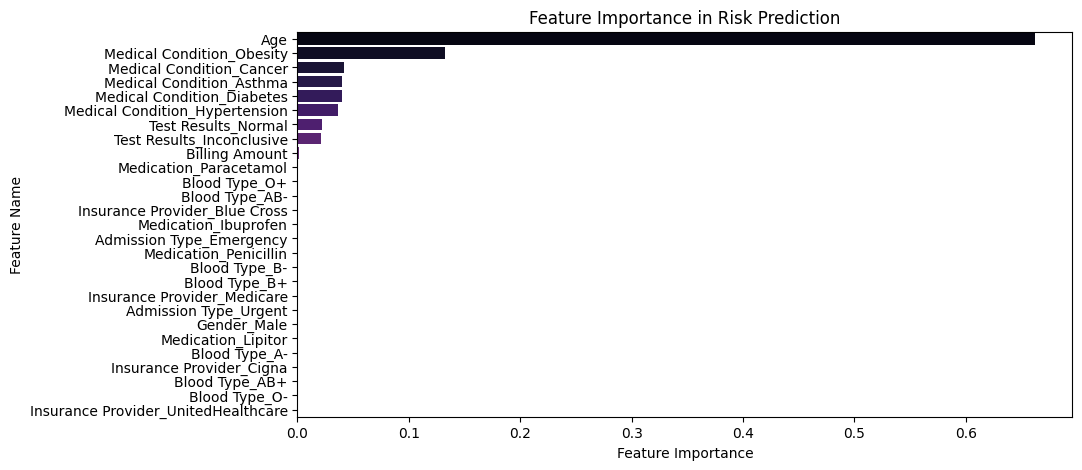

In [90]:
feature_importance = rf_model.feature_importances_
features = X_class.columns
feature_df = pd.DataFrame({"Feature": features, "Importance": feature_importance})
feature_df = feature_df.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=feature_df["Importance"], y=feature_df["Feature"], palette="magma")
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("Feature Importance in Risk Prediction")
plt.show()

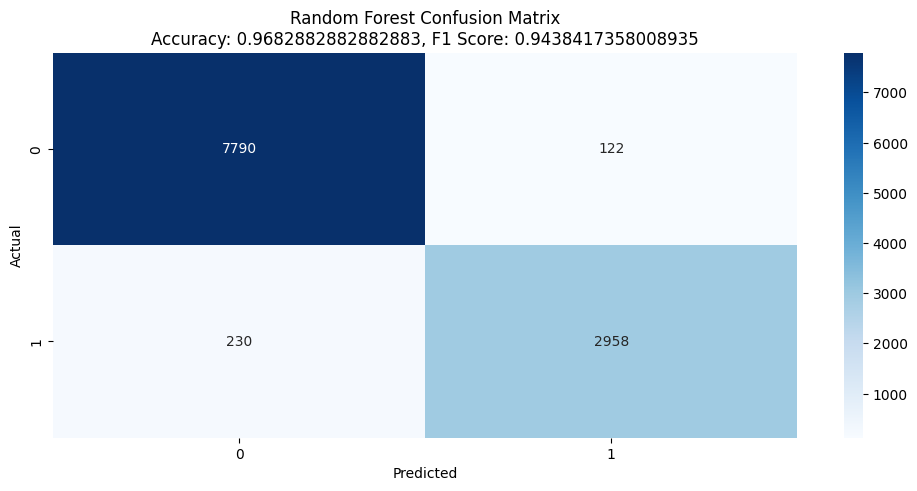

In [91]:
plt.figure(figsize=(12,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Random Forest Confusion Matrix\nAccuracy: {accuracy:}, F1 Score: {f1:}')
plt.show()

**Insights**


Knowing patient risk levels (e.g., High-Risk vs. Low-Risk) enables hospitals to allocate ICU beds, ventilators, and medical staff appropriately.


Patients predicted to have longer hospital stays (e.g., due to heart disease, diabetes) should be monitored more closely.
If a model predicts higher patient inflow, hospitals can adjust shift schedules to ensure adequate staff availability.



By using AI-powered predictive analytics, hospitals can optimize bed availability, reduce costs, improve patient satisfaction, and ensure compliance with regulations. Implementing an intelligent hospital bed management system can significantly enhance operational efficiency and patient outcomes.